# Scrapy worker report

20 workers, maximum concurrency of 10 requests per worker

A set of visualizations to inspect the performance of a run of the scrapy parallization system. Takes maybe 10 minutes to run, since it recomputes batches and then has to accumulate a bunch of timestamps-


In [1]:
#The plan here is to
# 1, check completeness across batches- just load in the batch and see the count
# 2, check timeframe for each batch- each has a *_ts file recording when it was saved

from pathlib import Path
import datetime
import matplotlib.pyplot as plt
import json
import csv
from pprint import pprint

DATADIR = "../../../data"

#Set the date
date = datetime.datetime(2023, 5, 18)

datapath = f"{DATADIR}/{date.year}/{date.month}/{date.day}/"


In [2]:
#Count the total number of links in each batchfile

batchfiles = list(Path(datapath).glob("batchfile_[0-9]*.csv"))
batch_totals = {}
print(batchfiles)
for batch in batchfiles:
    batch_id = int(batch.name.split("_")[-1].split(".")[0])
    count = 0
    with batch.open() as b:
        reader = csv.DictReader(b)
        for row in reader:
            count += 1
    batch_totals[batch_id] = count
    
num_batches = len(batch_totals)
print(batch_totals)

[PosixPath('../../../data/2023/5/18/batchfile_0.csv'), PosixPath('../../../data/2023/5/18/batchfile_1.csv')]
{0: 5000, 1: 5000}


In [3]:
#Injest all of the http fetch metadata records

metadata_strs = list(Path(datapath+"/content").glob("*%-http_meta.json"))
batch_ts = {b:[] for b in batch_totals.keys()}
for md in metadata_strs:
    with md.open() as f:
        data = json.load(f)
        batch_ts[data['fetch_batch']].append(data['fetch_timestamp'])

            
            
total = 0
for batch, ts in batch_ts.items():
    batch_total = batch_totals[batch]
    print(f"Batch {batch}: {len(ts)} successful fetches, {len(ts)/batch_total} completion")
    total += len(ts)
    
    
total_target = sum(i for i in batch_totals.values())
print(total_target)
if total_target > 0:
    print(f"Overall: {total} successful fetches, {total/total_target} completion")



Batch 0: 1853 successful fetches, 0.3706 completion
Batch 1: 1244 successful fetches, 0.2488 completion
10000
Overall: 3097 successful fetches, 0.3097 completion


In [4]:
#gotta do this kinda hacky for now, since I don't record when the batch actually begins running. 
start_ts = {k:min(v) for k, v in batch_ts.items() if len(v) > 0}


In [5]:
def batch_timeframe(batch_index, ts=batch_ts, start=start_ts, steps= 100):
    
    if batch_index not in start:
        return None, None, None
    
    starttime = start[batch_index]
    
    batchts = ts[batch_index]
    
    events = []
    
    if(len(batchts)==0):
        return None, None, None
    
    for time in batchts:
        
        duration = time - starttime
        events.append(duration)
        
    top = int(max(events)+1)
    inc = top / steps
    head = 0
    accumulator = {}
    for i in range(steps):
        value = len([e for e in events if e <= head])
        accumulator[head] = value
        head += inc
    
    return accumulator, top-1, len(batchts)
    


def plot_batch_timeframe(batch_index, totals=batch_totals):
    tf, time, num = batch_timeframe(batch_index)
    if tf is None:
        stats = {"batch_index":0,
                "num_collected": 0,
                "total_duration": 0, 
                "rate": 0,
                "interval": 0,
                "percent":0,
                }
        fstr = f"batch {batch_index} collected zero files"
        return stats
    
    total = totals[batch_index]
    
    x = tf.keys()
    y = tf.values()
    
    w = max(x)/len(x)
    
    fix, ax = plt.subplots()
    ax.set_title(f"Scrapy task consumption over time for batch {batch_index}")
    ax.bar(x, y, width=w, linewidth=0.7)
    ax.set_ylim([0, total])
    
    plt.show()
    
    num = list(y)[-1]
    if num == 0:
        stats = {"batch_index":batch_index,
                "num_collected": 0,
                "total_duration": 0, 
                "rate": 0,
                "interval": 0,
                "percent":0,
                }
    else:
        stats = {"batch_index":batch_index,
             "num_collected": num,
             "total_duration": time, 
             "rate": num/time,
             "interval": time/num,
             "percent": num/total}
   
    #print(fstr)
    return stats
    
def report(s):
    o = f"""

Batch {s['batch_index']} collected {s["num_collected"]} pages in {s['total_duration']}.    
{s['rate']} per second,
{s['interval']} per fetch,
{s['percent']} coverage of target. 
{'#'*60}    
    
    """
    return o

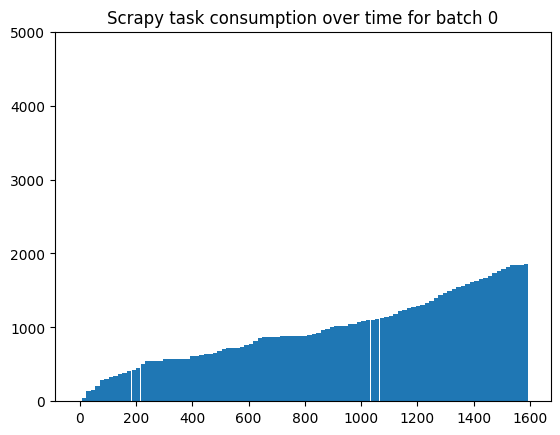



Batch 0 collected 1851 pages in 1601.    
1.156152404747033 per second,
0.8649378714208535 per fetch,
0.3702 coverage of target. 
############################################################    
    
    


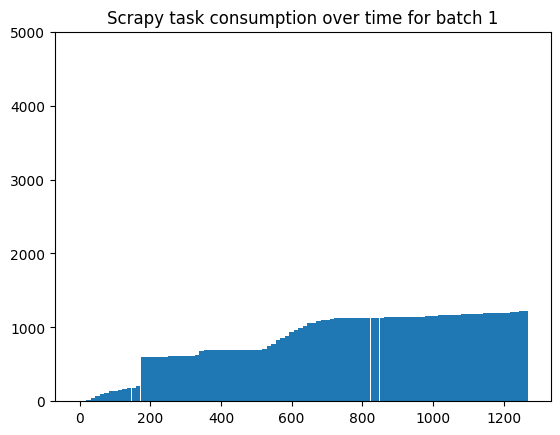



Batch 1 collected 1226 pages in 1275.    
0.9615686274509804 per second,
1.0399673735725938 per fetch,
0.2452 coverage of target. 
############################################################    
    
    


In [6]:
stats = []
for i in range(num_batches):
    s = plot_batch_timeframe(i)
    stats.append(s)
    print(report(s))

1684987442.694904


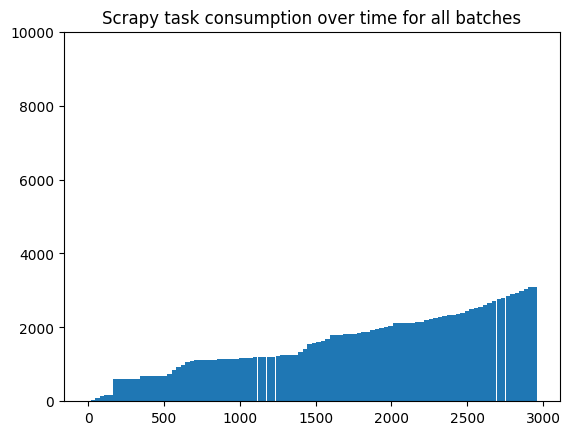



Batch Total collected 3093 pages in 2976.    
1.0393145161290323 per second,
0.962172647914646 per fetch,
0.3093 coverage of target. 
############################################################    
    
    


In [7]:
def total_progress_plot(ts=batch_ts, start_events=start_ts, totals=batch_totals, steps= 100):
    #accumulate all timestamps into one progress meter
    all_ts = []
    [all_ts.extend(list(t)) for t in ts.values()]
    events = []
    
    #use earliest 'start' stamp as a start
    
    start_ = min(t for t in start_events.values())
    print(start_)
    for time in all_ts:
        duration = time - start_
        events.append(duration)
        

        
    top = int(max(events)+1)
    inc = top / steps
    head = 0
    accumulator = {}
    for i in range(steps):
        value = len([e for e in events if e <= head])
        accumulator[head] = value
        head += inc
    
    #and use sum of totals as target
    target = sum(t for t in totals.values())
    
    x = accumulator.keys()
    y = accumulator.values()
    
    w = max(x)/len(x)
    
    fix, ax = plt.subplots()
    ax.set_title(f"Scrapy task consumption over time for all batches")
    ax.bar(x, y, width=w, linewidth=0.7)
    ax.set_ylim([0, target])
    
    plt.show()
    
    num = list(y)[-1]
    time = top
    
    stats = {"batch_index":"Total",
             "num_collected": num,
             "total_duration": time, 
             "rate": num/time,
             "interval": time/num,
             "percent": num/target}
    return stats
    
    
overall_stats = total_progress_plot()
print(report(overall_stats))